# Machine Learning: Classification

_When you come to a fork in the road, take it_ - Yogi Berra 

We apply supervised learning models to a text classification task, using natural language processing (NLP) techniques to analyze business descriptions from the latest 10-K filings. Our goal is to predict firms’ industry classifications, evaluating models such as Naive Bayes, Perceptron, Support Vector Machine (SVM), and Logistic Regression. We assess model performance using metrics like the confusion matrix and examine interpretability by visualizing feature importances.

In [1]:
# By: Terence Lim, 2020-2025 (terence-lim.github.io)
import time
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import text
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.unstructured import Edgar
from finds.structured import BusDay, CRSP, PSTAT
from finds.readers import Sectoring
from finds.utils import Store
from secret import paths, credentials, CRSP_DATE
# %matplotlib qt
VERBOSE = 0
store = Store('assets', ext='pkl')

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)
pstat = PSTAT(sql, bd, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)

## Text classification

Hoberg and Phillips (2016) proposed a system for classifying firms based on their business descriptions in 10-K filings, using these descriptions to measure firm similarity. We extend their analysis for text-based industry classification, focusing on U.S.-domiciled common stocks. The text data for each firm is drawn from the most recent year's Business Description section of their 10-K filings.

In [3]:
# Retrieve universe of stocks, as of beginning of latest year
univ = crsp.get_universe(bd.endyr(CRSP_DATE, -1))

In [4]:
# Construct table to lookup company names
comnam = crsp.build_lookup(source='permno', target='comnam', fillna="")
univ['comnam'] = comnam(univ.index)

In [5]:
# Construct table to lookup ticker symbols
ticker = crsp.build_lookup(source='permno', target='ticker', fillna="")
univ['ticker'] = ticker(univ.index)

In [6]:
# Construct table to lookup sic codes from Compustat, and map to FF 10-sector code
sic = pstat.build_lookup(source='lpermno', target='sic', fillna=0)
industry = Series(sic[univ.index], index=univ.index)
industry = industry.where(industry > 0, univ['siccd'])
sectors = Sectoring(sql, scheme='codes10', fillna='')   # supplement from crosswalk
univ['sector'] = sectors[industry]

### Text pre-processing

The pre-processing step involves several key operations to clean and prepare the text for analysis. We begin by extracting the Business Description text from the most recent 10-K filings of all stocks in our dataset. 

In [7]:
# retrieve latest year's bus10K's
item, form = 'bus10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
found = rows[rows['date'].between(bd.begyr(CRSP_DATE), bd.endyr(CRSP_DATE))]\
             .drop_duplicates(subset=['permno'], keep='last')\
             .set_index('permno')


- The text is then **lemmatized** using WordNet’s built-in morphy function, which reduces words to their base or root form. This step helps standardize the text by consolidating variations of words into their common form. 

In [8]:
# !nltk.download('averaged_perceptron_tagger')
lemmatizer = WordNetLemmatizer()


100%|██████████| 4488/4488 [11:25<00:00,  6.55it/s]


- Next, we apply the **part-of-speech (POS) tagger** from the `nltk` library, retaining only nouns, which are the most informative about for industry classification tasks. 

In [ ]:
bus = {}
for permno in tqdm(found.index):
    if permno not in univ.index:
        continue
    doc = word_tokenize(ed[found.loc[permno, 'pathname']].lower())
    tags = pos_tag(doc)
    nouns = [lemmatizer.lemmatize(w[0]) for w in tags
             if w[1] in ['NN', 'NNS'] and w[0].isalpha() and len(w[0]) > 2]
    if len(nouns) > 100:
        bus[permno] = nouns
store['nouns'] = bus

In [9]:
bus = store.load('nouns')
permnos = list(bus.keys())
labels = univ.loc[permnos, 'sector']
data = [" ".join(list(nouns)) for nouns in bus.values()]
classes = sorted(np.unique(labels))

- Finally, we split the corpus into training and testing samples, stratifying the data is to maintain the distribution of class labels in both sets.


In [10]:
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=test_size, random_state=42, stratify=labels)
summary = Series(y_train).value_counts().rename('n_train').to_frame()
summary['n_test'] = Series(y_test).value_counts()
summary['frac_train'] = summary['n_train'] / summary['n_train'].sum()
summary['frac_test'] = summary['n_test'] / summary['n_test'].sum()
print('Stratified Train/Test Split by Event')
summary.sort_values('n_train', ascending=False).round(2)

Stratified Train/Test Split by Event


,n_train,n_test,frac_train,frac_test
sector,,,,
Hlth,657,164,0.24,0.24
Other,612,153,0.22,0.22
HiTec,554,139,0.20,0.20
Manuf,275,69,0.10,0.10
Shops,246,62,0.09,0.09
Durbl,131,33,0.05,0.05
NoDur,114,28,0.04,0.04
Enrgy,81,20,0.03,0.03
Utils,72,18,0.03,0.03


### Text vectorization

After pre-processing the text, we convert the textual data into numerical features that can be fed into machine learning models. This is achieved through the **Term Frequency-Inverse Document Frequency (TF-IDF)** method. TF-IDF weights terms based on their importance in a document relative to their frequency in a collection of documents (corpus). 

- **Term Frequency (TF)** measures how often a word appears in a document. A higher frequency suggests the word is more important within that document.
- **Inverse Document Frequency (IDF)** adjusts the weight of a term based on its rarity across the entire corpus. Terms that appear frequently across many documents are given less weight, while terms that appear less frequently are given greater importance.

To focus on the most relevant and informative words, we filter out extremely common words that appear in more than 50% of the documents (using `max_df=0.5`), exclude rare words that appear in fewer than 200 documents (using `min_df=200`), and limist the vocabulary to the 10,000 most frequent remaining terms (`max_features=10000`).

In [11]:
# Tfidf vectorizor
max_df, min_df, max_features = 0.5, 10, 20000
tfidf_vectorizer = text.TfidfVectorizer(
    encoding='latin-1',
    strip_accents='unicode',
    lowercase=True,
    #stop_words=stop_words,
    max_df=max_df,
    min_df=min_df,
    max_features=max_features,
    token_pattern=r'\b[a-z_]+\b',
)
x_train = tfidf_vectorizer.fit_transform(X_train)   # sparse array
x_test = tfidf_vectorizer.transform(X_test)
feature_names = tfidf_vectorizer.get_feature_names_out()
print("n_sample x n_features")
DataFrame([[x_train.shape, x_test.shape]],
          index=['data shape:'],
          columns=['train', 'test'])

n_sample x n_features


,train,test
data shape:,"(2779, 10060)","(695, 10060)"


## Classification models

In machine learning, there are generally two types of approaches for classification tasks: 

- **Generative models** estimate a probability distribution and define the classifier based on these estimates. An example of this is the Naive Bayes classifier.
- **Discriminative models** directly define a decision boundary between classes. Examples of discriminative models include Logistic Regression, Perceptron, and Support Vector Machines (SVM).

Define a helper function to compute and save accuracy scores for both the training and testing samples.

In [12]:
results = dict()

In [13]:
def update_results(name, clf, elapsed):
    """helper to update results dict with train and test accuracy"""
    tic = time.time()
    test_score = clf.score(x_test, y_test)
    toc = time.time() - tic
    results[name] = dict(model=clf,
                         train_score=clf.score(x_train, y_train),
                         test_score=test_score,
                         test_time=toc,
                         train_time=elapsed)
    #store['classification'] = results
    print('Accuracy')
    return DataFrame.from_dict(results, orient='index').iloc[:, 1:]

### Naive Bayes

The Naive Bayes classifier is a simple yet effective method for text classification. It assumes that the features (words) are conditionally independent given the class, meaning that the occurrence of one word in a document does not affect the occurrence of another. Despite this strong assumption, Naive Bayes performs surprisingly well on many real-world classification tasks.

- **Binomial Naive Bayes** is used for binary classification problems, where each document is assigned to one of two classes.
- **Multinomial Naive Bayes** is typically used for multi-class classification, where documents can belong to more than two classes.

Since Naive Bayes relies on the multiplication of probabilities for each feature, it can encounter problems when a feature has a zero probability in the training set. This is addressed through **Laplace smoothing**, which adds a small constant to all feature counts to avoid zero probabilities.

The basic formula for Naive Bayes classification is:
$$ P(f_1, f_2, ..., f_n | c) = P(f_1 | c) \cdot P(f_2 | c) \cdot ... \cdot P(f_n | c) $$

where $ P(f_i | c) $ is the probability of feature $ f_i $ occurring in class $ c $. The classification decision is made by selecting the class that maximizes the likelihood of the observed features, i.e.:
$$ \hat{c} = \arg \max_c \left( \log P(c) + \sum_{i=1}^n \log P(f_i | c) \right) $$

where the maximum likelihood estimate of the probability of
frequency of word $w_i$ is $P(w_{i} | c) =                                                                     
\frac{\mathrm{count}(w_{i},c)}{\sum_{w \in V} \mathrm{count}(w, c)}$

In [14]:
clf = MultinomialNB(alpha=1.0)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('naivebayes', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.751709,0.738129,0.002441,0.013695


### Perceptron

The Perceptron is a linear classifier that updates weights based on classification errors. It uses a 0-1 loss function, which assigns a loss of zero for correct classifications and a loss of one for incorrect ones. The update rule for the Perceptron is as follows:
- If the predicted label $ \hat{y} $ is different from the true label $ y $, the weight vector $ w $ is updated: 
  $$ w \leftarrow w + \alpha x (y - \hat{y}) $$
Where $ \alpha $ is the learning rate and $ x $ is the feature vector of the document.

In multiclass classification, the **One-vs-Rest (OVR)** approach is used, where the Perceptron is trained to distinguish between each class and the rest of the classes.

In [15]:
clf = Perceptron(penalty='elasticnet',
                 #n_jobs=4, # -1
                 random_state=0,
                 verbose=VERBOSE)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('perceptron', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.751709,0.738129,0.002441,0.013695
perceptron,0.949982,0.761151,0.004099,0.866820


### Support Vector Machine


Support Vector Machines (SVM) are powerful classifiers that work by finding the decision boundary that maximizes the margin between classes. The decision boundary is chosen to minimize classification errors, and SVM uses **hinge loss** to penalize misclassifications:
$$ \text{Loss} = \max(0, 1 - y(w \cdot x)) $$

SVM can handle both linear and non-linear decision boundaries by using different kernel functions. In this analysis, we use the **LinearSVC** kernel, which optimizes the classification with a linear decision boundary. For multiclass classification, SVM uses the One-vs-Rest (OVR) method.


In [16]:
clf = LinearSVC(multi_class='ovr',
                penalty='l2',
                verbose=VERBOSE)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('linearsvc', clf, toc)

/home/terence/env3.11/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.751709,0.738129,0.002441,0.013695
perceptron,0.949982,0.761151,0.004099,0.866820
linearsvc,0.990284,0.831655,0.002280,0.348787


### Logistic Regression

Logistic Regression is a widely used model for binary and multi-class classification tasks. It uses **cross-entropy loss** to measure the difference between predicted probabilities and actual class labels. The logistic regression model updates weights iteratively based on the gradient of the loss function:
- For a binary classification problem, the probability of class 1 is given by:
  $$ P(y=1 | x) = \frac{1}{1 + e^{-w x}} $$

The update step is:
 - $P(y=1 | x) \leftarrow 1/(1 + e^{-w x})$
 - $w \leftarrow w + \alpha ~ x ~(1 - P(y=1|x))$ if $y = 1$
- $w \leftarrow w - \alpha ~ x ~(1 - P(y=0|x))$ if $y = 0$

$\Leftrightarrow w \leftarrow w + \alpha ~ x ~(y - P(y=1|x))$ where $y \in \{0,~1\}$

In multiclass problems, **softmax** is used to generalize logistic regression, providing a probability distribution over all classes. The model's weights are updated using gradient descent to minimize the cross-entropy loss.



In [17]:
clf = LogisticRegression(verbose=VERBOSE,
                         penalty='l2',
                         multi_class='multinomial',
                         # n_jobs=-1,      # when multi_class='ovr'
                         max_iter=1000)
tic = time.time()
clf.fit(x_train, y_train)
toc = time.time() - tic
update_results('logistic', clf, toc)

Accuracy


,train_score,test_score,test_time,train_time
naivebayes,0.751709,0.738129,0.002441,0.013695
perceptron,0.949982,0.761151,0.004099,0.866820
linearsvc,0.990284,0.831655,0.002280,0.348787
logistic,0.896366,0.833094,0.005731,3.705192


## Evaluation

### Overfitting

Evidence of overfitting can be observed when a model performs well on the training data but poorly on the test data. In such cases, the model may have learned to memorize the training data instead of generalizing to new examples. Overfitting can be mitigated by using techniques like cross-validation and regularization.

### Accuracy Metrics

To evaluate model performance, we consider several metrics:
- **Precision**: The proportion of true positive predictions among all positive predictions.
- **Recall**: The proportion of true positive predictions among all actual positive cases.
- **F1 Score**: The harmonic mean of precision and recall, which balances the two metrics and provides a single score for model performance.

In multiclass and multilabel scenarios, the F1 score is computed as a weighted average of the F1 scores for each class.



In [18]:
# Compute precision, recall, f1 and confusion matrix
res = DataFrame.from_dict(results, orient='index')
models = {k: v['model'] for k,v in results.items()}

scores, cf_test, cf_train = {}, {}, {}
for ifig, (name, clf) in enumerate(models.items()):
    train_pred = clf.predict(x_train)
    test_pred = clf.predict(x_test)
    scores[name] = {
        'train': metrics.precision_recall_fscore_support(
            y_train, train_pred, average='macro')[:3],
        'test': metrics.precision_recall_fscore_support(
            y_test, test_pred, average='macro')[:3]
    }
    cf = DataFrame(confusion_matrix(y_train, train_pred, labels=classes),
                   index=pd.MultiIndex.from_product([['Actual'], classes]),
                   columns=pd.MultiIndex.from_product([['Predicted'], classes]))
    cf_train[name] = cf
    cf = DataFrame(confusion_matrix(y_test, test_pred, labels=classes),
                   index=pd.MultiIndex.from_product([['Actual'], classes]),
                   columns=pd.MultiIndex.from_product([['Predicted'], classes]))
    cf_test[name] = cf


/home/terence/env3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/terence/env3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [19]:
caption="Model Accuracy"
DataFrame({(metric, sample): [score[sample][i] for score in scores.values()]
           for i, metric in enumerate(['Precision', 'Recall', 'F1-score'])
           for sample in ['train', 'test']},
          index=scores.keys())

Precision              Recall            F1-score          
               train      test     train      test     train      test
naivebayes  0.758517  0.747060  0.522357  0.498908  0.541932  0.513666
perceptron  0.942079  0.732010  0.953285  0.765879  0.946463  0.741730
linearsvc   0.990133  0.809224  0.993392  0.811619  0.991729  0.806204
logistic    0.901001  0.823311  0.844640  0.793319  0.867906  0.805434

### Confusion Matrix

A confusion matrix provides a detailed breakdown of the classification results, showing the true positive, false positive, true negative, and false negative counts for each class.


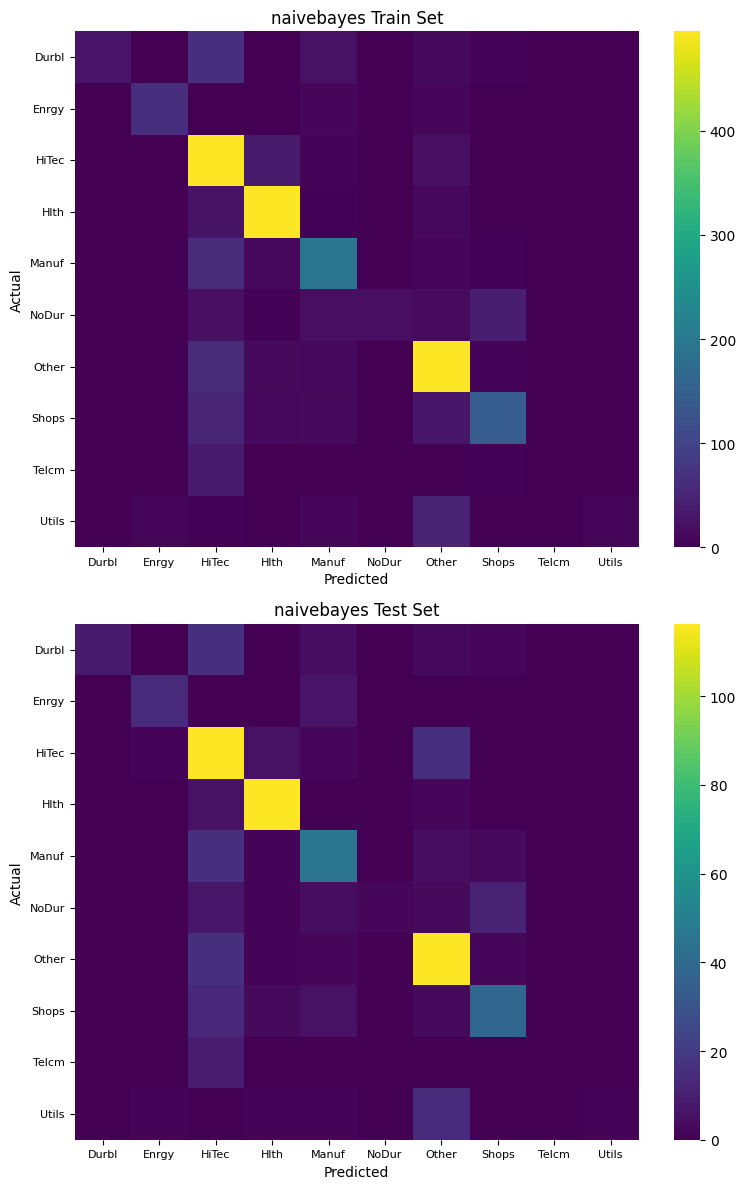

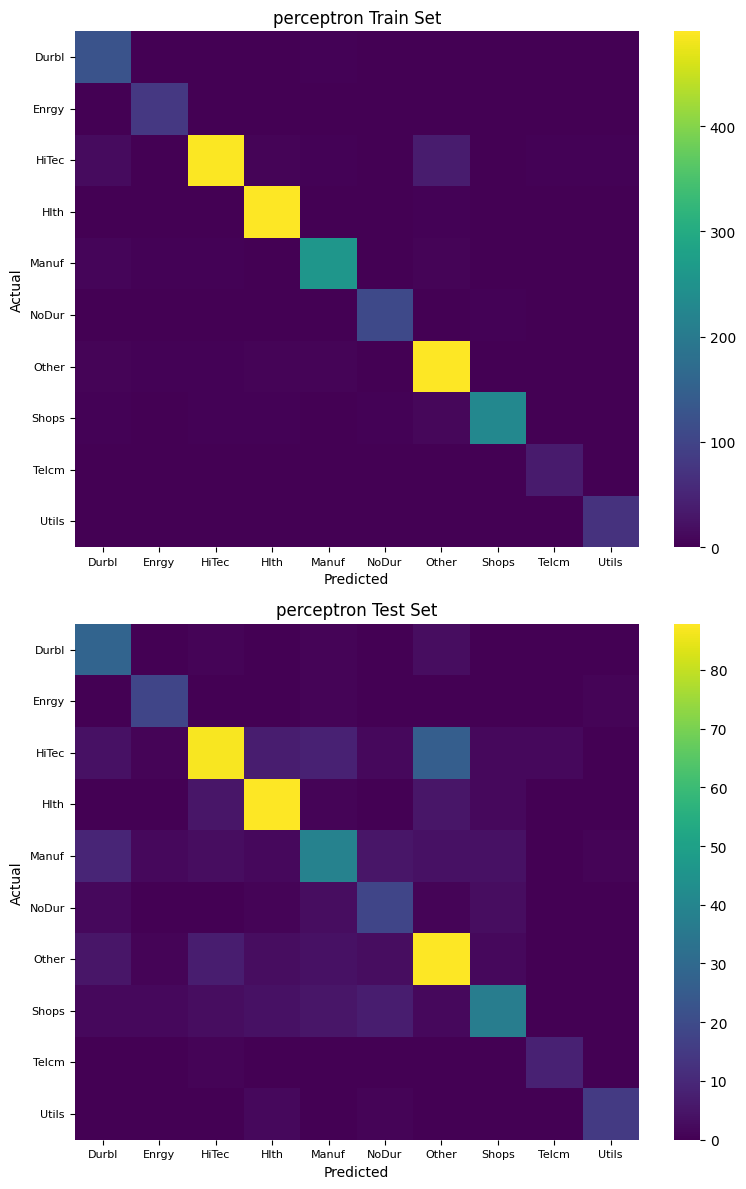

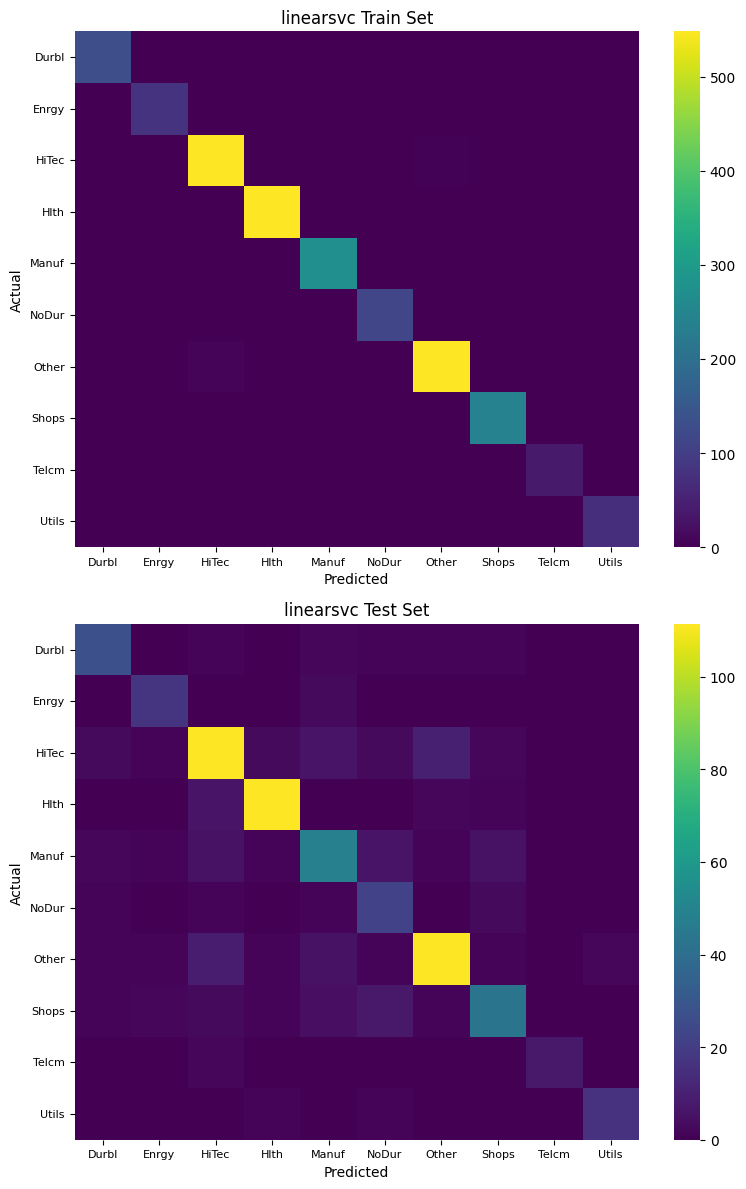

In [20]:
for name, model in models.items():
    fig, axes = plt.subplots(nrows=2, figsize=(8, 12))
    for label, cf, ax in [('Train Set', cf_train[name], axes[0]), 
                          ('Test Set', cf_test[name], axes[1])]:
        sns.heatmap(cf, ax=ax, annot= False, fmt='d', cmap='viridis', robust=True,
                    yticklabels=model.classes_,
                    xticklabels=model.classes_)
        ax.set_title(f"{name} {label}")
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')
        ax.yaxis.set_tick_params(labelsize=8, rotation=0)
        ax.xaxis.set_tick_params(labelsize=8, rotation=0)
        #plt.subplots_adjust(left=0.35, bottom=0.25)
        plt.tight_layout()
plt.close()

### Feature importance

Feature importance can be assessed by examining the weights or probabilities assigned to each term in the model, allowing us to visualize the most important terms for each class.  For Naive Bayes, the weights can be exponentiated to probabilities

**Word clouds**, facilitated by packages such as `WordCloud`, can help visualize the most frequent and important words in the dataset, highlighting the key terms that influence classification decisions.

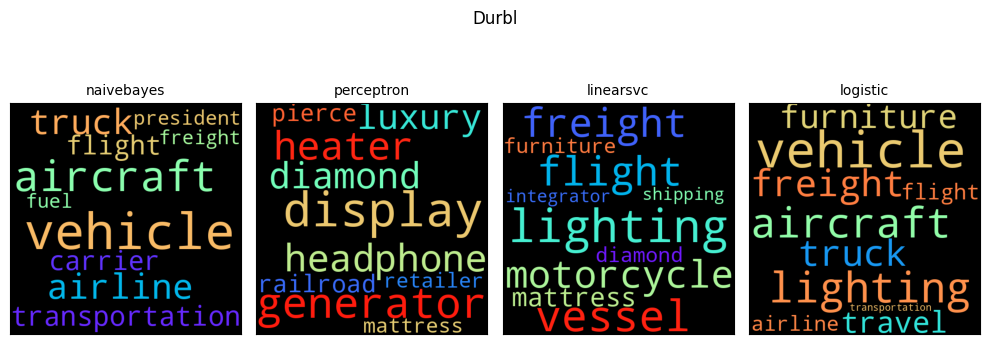

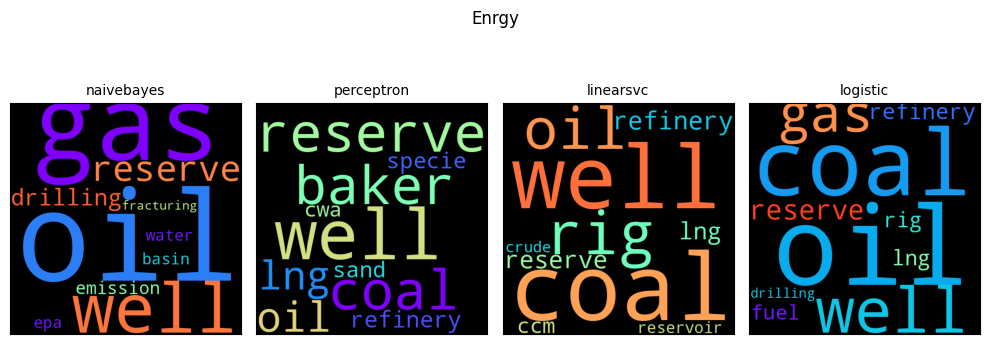

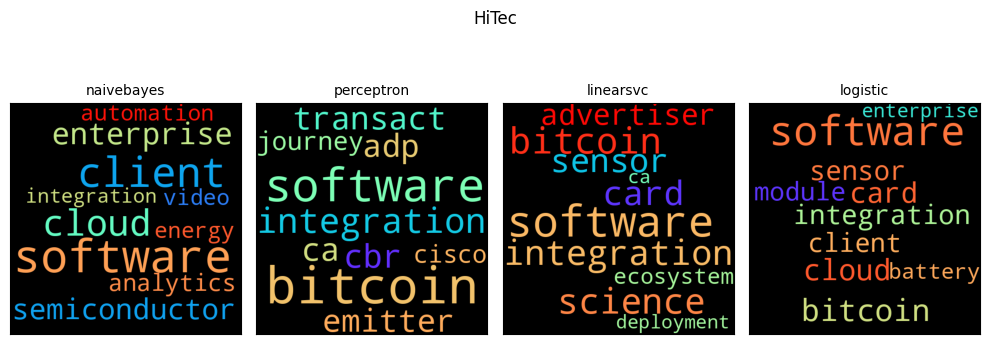

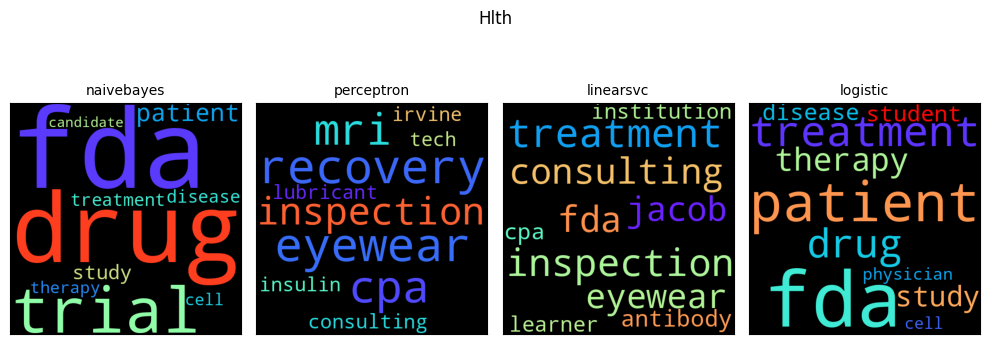

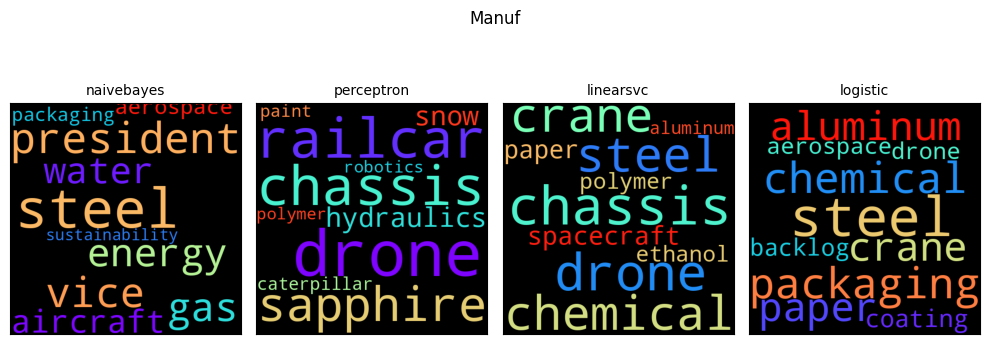

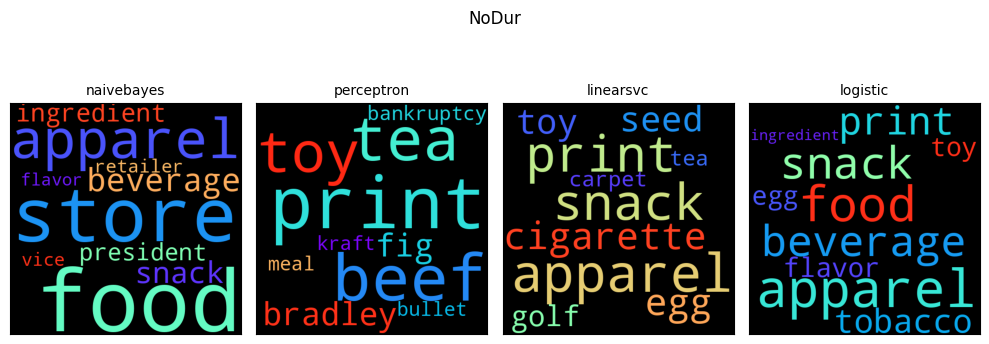

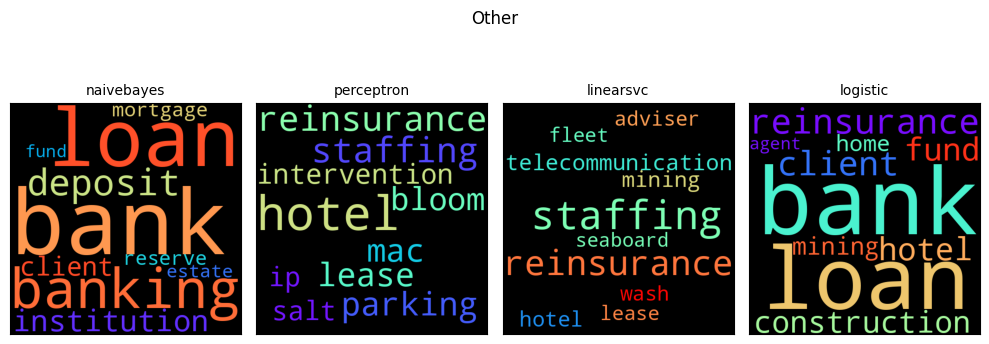

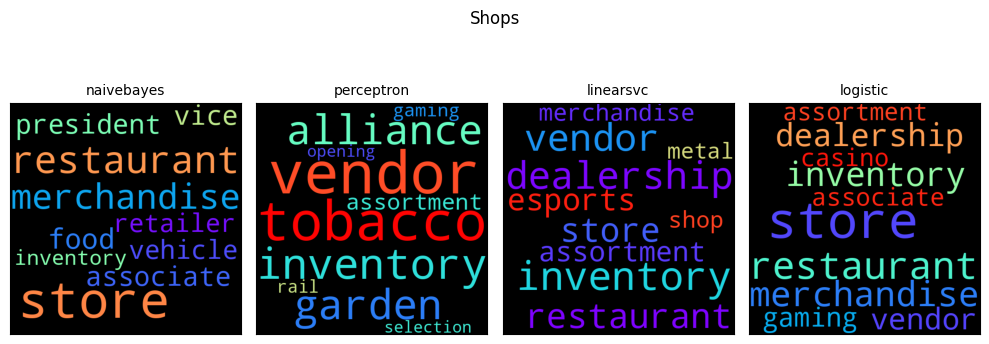

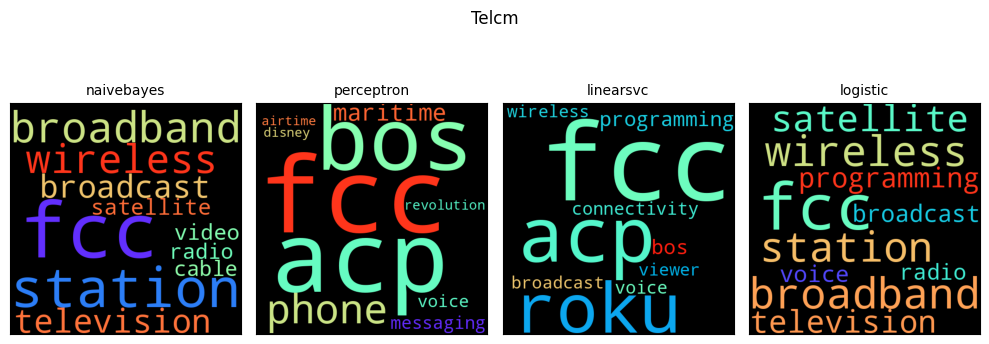

In [21]:
wc = WordCloud(height=500, width=500, prefer_horizontal=1.0, colormap='rainbow') 

top_n = 10
for topic in classes:   # loop over classes
    fig, axes = plt.subplots(ncols=len(models), nrows=1, figsize=(10, 4))
    fig.suptitle(topic)
    for imodel, (ax, name, clf) in enumerate(zip(
            axes, models.keys(), models.values())):
        assert hasattr(clf, 'coef_') or hasattr(clf, 'feature_log_prob_')
        k = clf.classes_.tolist().index(topic)
        #print("Event %d %s:" % (topic, events_[clf.classes_[topic]]))
        if hasattr(clf, 'coef_'):
            importance = clf.coef_[k, :]
        else:
            importance = np.exp(clf.feature_log_prob_[k, :])
        words = {feature_names[i]: importance[i] 
                 for i in importance.argsort()[-top_n:]}
        ax.imshow(wc.generate_from_frequencies(words))
        #Series(words).plot(kind='barh', color=f"C{imodel}", ax=ax)
        #ax.yaxis.set_tick_params(labelsize=7)
        ax.axes.yaxis.set_visible(False)   # make axes ticks invisible
        ax.xaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.set_title(name, fontdict={'fontsize':10})
    fig.tight_layout()
plt.close()


__References:__

Gareth James, Daniela Witten, Trevor Hastie, Robert Tibshirani. "An Introduction to Statistical Learning with Applications in R". New York, Springer, 2013.

Gerard Hoberg and Gordon Phillips, 2016, Text-Based Network Industries and Endogenous Product Differentiation.Journal of Political Economy 124 (5), 1423-1465.

Gerard Hoberg and Gordon Phillips, 2010, Product Market Synergies and Competition in Mergers and Acquisitions: A Text-Based Analysis. Review of Financial Studies 23 (10), 3773-3811. 